In [55]:
device="cpu"
#device="cuda"
import io
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import numpy as np

In [56]:
class CPU_Unpickler(pickle.Unpickler):
    import io
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

class FakeArgs:
    """
    A simple class imitating the args namespace
    """

    def __repr__(self):
        attrs = vars(self)
        return "\n".join([f"{k}: {v}" for k, v in attrs.items()])

def get_phenotypes(args, pop, num_indv, complexities, if_comp):
  state = torch.zeros(num_indv, 1, args.grn_size).to(device)
  state[:, :, 0] = 1.0 # create input to the GRNs

  state_before = torch.zeros(num_indv, 1, args.grn_size).to(device) # keeping track of the last state
  for l in range(args.max_iter):
    state = torch.matmul(state, pop) # each matrix in the population is multiplied
    state = state * args.alpha
    state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
    # state = dround(state, 2)
    diffs=torch.abs(state_before - state).sum(axis=(1,2))
    which_repeat = torch.where(diffs == 0)
    if if_comp:
      complexities[which_repeat] += 1
    state_before = state

  if if_comp:
    return state, complexities
  else:
    return state

In [57]:
def get_internal_states(grn):
  grn=grn.to(device)
  states=[]
  state = torch.zeros(1, 1, args.grn_size).to(device)
  state[:, :, 0] = 1.0 # create input to the GRNs

  state_before = torch.zeros(1, 1, args.grn_size).to(device) # keeping track of the last state
  for l in range(args.max_iter):
    states.append(state)
    state = torch.matmul(state, grn) # each matrix in the population is multiplied
    state = state * args.alpha
    state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
    # state = dround(state, 2)
    diffs=torch.abs(state_before - state).sum(axis=(1,2))
    which_repeat = torch.where(diffs == 0)
    state_before = state

  states=torch.stack(states)
  states=torch.flatten(states,start_dim=1)
  return states


In [58]:
# open a file, where you stored the pickled data
file = open('results/scintillating-wish-132/BASIC.pkl', 'rb')

# dump information to that file
#data = pickle.load(file)
data = CPU_Unpickler(file).load()

In [59]:
data.keys()

dict_keys(['max_fits', 'ave_fits', 'st_div_fits', 'ave_complex', 'delta_fit_envchange', 'delta_fit_envchange_max', 'rebound_time', 'rebound_time_max', 'max_ages', 'ave_ages', 'best_grns', 'diversities', 'low', 'spec_A', 'spec_B', 'gen', 'kid_stds', 'args_used'])

In [60]:
#check_at=556
check_at = 1520#20000#lucky rooster 1513
#check_at = -1

In [51]:
#sns.distplot(torch.flatten(data["best_grns"][0])) #density=True, alpha = 0.3)
#sns.distplot(torch.flatten(data["best_grns"][-1]))
#sns.distplot(torch.flatten(data["best_grns"][check_at]))
#plt.hist(torch.flatten(data["best_grns"][-1]), density=True)

In [61]:
final_weights=data["best_grns"][check_at]
args = data["args_used"]
#final_weights = np.clip(final_weights,-0.001,0.001)

In [62]:
final_weights = torch.Tensor(final_weights)

In [63]:
best_pheno=get_phenotypes(args, final_weights.to(device), 1, 3, False)

In [64]:
#plt.matshow(data["best_grns"][-1])
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cax = ax.matshow(final_weights)
#fig.colorbar(cax)

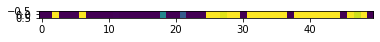

In [65]:
fig = plt.figure(figsize=(6,4))
#ax = fig.add_subplot(111)
#cax = ax.plot(best_pheno[0][0].cpu(),'.')
#plt.plot(best_pheno[0][0].cpu(),'.')
a = np.expand_dims(np.array(best_pheno[0][0].cpu()), axis=0)
plt.imshow(a)
#fig.colorbar(cax)

In [66]:
num_clones=20
complexities = 0
num_genes_fit = 50

clones = final_weights.to(device).repeat([num_clones, 1, 1]) # create copies of parents

# Mutate clones
num_genes_mutate = int(args.grn_size*args.grn_size*len(clones) * args.mut_rate)
mylist = torch.zeros(args.grn_size*args.grn_size*len(clones), device=device)
mylist[:num_genes_mutate] = 1
shuffled_idx = torch.randperm(args.grn_size*args.grn_size*len(clones), device=device)
mask = mylist[shuffled_idx].reshape(len(clones),args.grn_size,args.grn_size) #select genes to mutate
clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * args.mut_size  # mutate only children only at certain genes

# Get clone phenotypes
clone_states=get_phenotypes(args, clones, num_clones, complexities, if_comp= False)
clone_phenos = clone_states[:,:,:num_genes_fit]
        
#c_genotypes = torch.stack(c_genotypes)
#c_phenotypes = torch.stack(c_phenotypes)

# Calculate fitness from phenotypes of clones
#c_phenotypes=torch.squeeze(c_phenotypes)
#tops=c_phenotypes[: , :  , :int(num_genes_fit/2)].sum(axis=-1, keepdims=True)
#bots=c_phenotypes[: , :  , int(num_genes_fit/2):].sum(axis=-1, keepdims=True)

<Figure size 144x144 with 0 Axes>

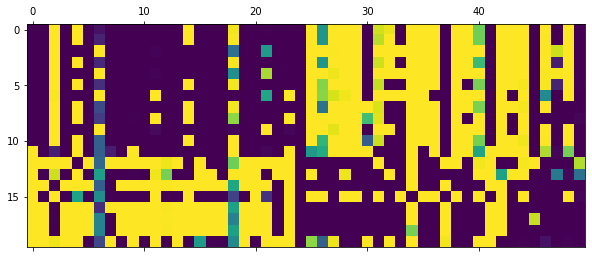

In [67]:
fig = plt.figure(figsize=(2,2))
#ax = fig.add_subplot(111)
#cax = ax.matshow(torch.squeeze(clone_phenos).cpu())
#plt.matshow(torch.squeeze(clone_phenos).cpu())
plt.matshow(torch.squeeze(clone_phenos).cpu()[torch.squeeze(clone_phenos).cpu()[:, 0].sort()[1]])
#fig.colorbar(cax)

In [37]:
#np.save("gen2_clones_phenos",np.array(clone_phenos))

In [38]:
#np.save("gen2_parent_phenos",np.array(best_pheno[0][0].cpu()))

In [39]:
#helper functions
def fitness_function(pop, targ):
    return (1 - torch.abs(pop.squeeze(1) - targ)).sum(axis=1) /pop.size()[-1] # the smaller the difference, the higher the fitness
def get_phenotypes(pop, num_indv):
    state = torch.zeros(num_indv, 1, grn_size).to(device)
    state[:, :, 0] = 1.0 # create input to the GRNs

    state_before = torch.zeros(num_indv, 1, grn_size).to(device) # keeping track of the last state
    for l in range(max_iter):
        state = torch.matmul(state, pop) # each matrix in the population is multiplied
        state = state * alpha
        state = torch.sigmoid(state) # after which it is put in a sigmoid function to get the output, by default alpha = 1 which is pretty flat, so let's use alpha > 1 (wagner uses infinite) hence the above multiplication
        # state = dround(state, 2)
        diffs=torch.abs(state_before - state).sum(axis=(1,2))
        which_repeat = torch.where(diffs == 0)
        state_before = state

    return state

ones=torch.ones(1,int(50/2)).to(device)
zeros=torch.zeros(1,int(50/2)).to(device)
targA=torch.cat((ones,zeros),1)
targB=torch.cat((zeros,ones),1)
targs = [targA,targB]

grn_size=50
alpha=10
mut_rate=0.1
mut_size=0.5
max_iter=100
    

#the real deal
def switcher_coeff(grn):
    num_clones=60
    num_genes_fit = 50
    
    grn=torch.Tensor(grn)
    
    c_phenotypes = []
    
    for c in range(num_clones):
        
        clones = grn.clone().to(device)#.repeat([num_clones, 1, 1]) # create copies of parents

        # Mutate clones
        num_genes_mutate = int(grn_size*grn_size*len(clones) * mut_rate)
        mylist = torch.zeros(grn_size*grn_size*len(clones), device=device)
        mylist[:num_genes_mutate] = 1
        shuffled_idx = torch.randperm(grn_size*grn_size*len(clones), device=device)
        mask = mylist[shuffled_idx].reshape(len(clones),grn_size,grn_size) #select genes to mutate
        clones = clones + (clones*mask)*torch.randn(size=clones.shape, device=device) * mut_size  # mutate only children only at certain genes

        # Get clone phenotypes
        clone_states=get_phenotypes(clones, 1)
        clone_phenos = clone_states[:,:,:num_genes_fit]
        
        c_phenotypes.append(clone_phenos)
    
    c_phenotypes = torch.stack(c_phenotypes)
    print(c_phenotypes)

    # Calculate fitness from phenotypes of clones
    c_phenotypes=torch.squeeze(c_phenotypes)
    tops=c_phenotypes[: , :  , :int(num_genes_fit/2)].sum(axis=-1, keepdims=True)
    bots=c_phenotypes[: , :  , int(num_genes_fit/2):].sum(axis=-1, keepdims=True)

    across_envs=abs(tops-bots).sum(axis=0) # sum of differences across clones between top and bottom half (i.e. envs). we want this to be high! we want the tops and bots to be different
    across_clones=abs(tops.sum(axis=0) - bots.sum(axis=0)) # for each individual, difference between tops and bots across the clones. you want this to be low
    across_envs=across_envs/(int(num_genes_fit/2)*num_clones) # number of genes/2 times number of clones
    across_clones=1-(across_clones/(int(num_genes_fit/2)*num_clones)) # number of genes/2 times number of clones, also the lower the better so let's flip

    newfitnesses=across_envs + across_clones - 1
    fitnesses=torch.squeeze(newfitnesses)
    
    return fitnesses
    
def generalist_coeff(grn):
    grn=torch.Tensor(grn)
    
    pheno=get_phenotypes(grn, 1)
    fitness = (1-(abs(pheno-0.5).mean())-0.5)*2
    
    return fitness.item()

def mutate_grn(grn):
    grn=torch.Tensor(grn)
    
    num_genes_mutate = int(grn_size*grn_size*1 * mut_rate)
    mylist = torch.zeros(grn_size*grn_size*1, device=device)
    mylist[:num_genes_mutate] = 1
    shuffled_idx = torch.randperm(grn_size*grn_size*1, device=device)
    mask = mylist[shuffled_idx].reshape(1,grn_size,grn_size) #select genes to mutate
    grn = grn + (grn*mask)*torch.randn(size=grn.shape, device=device) * mut_size  # mutate only children only at certain genes
    
    grn=torch.flatten(grn, start_dim=0, end_dim=1)
    
    return grn.detach().cpu().numpy()
    

In [68]:
tester=data["best_grns"][check_at].detach().cpu().numpy()

In [164]:
switcher_coeff(tester)

tensor([[[[5.5820e-11, 1.4847e-06, 4.2101e-16,  ..., 1.0000e+00,
           1.0000e+00, 9.6809e-01]],

         [[5.8337e-10, 1.4827e-06, 5.7322e-16,  ..., 1.0000e+00,
           1.0000e+00, 9.6456e-01]],

         [[1.3953e-02, 1.0000e+00, 1.0000e+00,  ..., 1.3394e-36,
           2.4679e-01, 7.0713e-11]],

         ...,

         [[4.5470e-03, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           2.5174e-27, 8.4979e-17]],

         [[5.5948e-11, 1.4829e-06, 4.1503e-16,  ..., 1.0000e+00,
           1.0000e+00, 9.6465e-01]],

         [[1.7310e-15, 1.0000e+00, 9.9999e-01,  ..., 1.0000e+00,
           1.0000e+00, 2.8754e-15]]],


        [[[8.3390e-14, 7.2390e-06, 4.2180e-16,  ..., 1.0000e+00,
           1.0000e+00, 9.6426e-01]],

         [[8.9123e-01, 1.0000e+00, 9.9998e-01,  ..., 1.2556e-33,
           1.0000e+00, 5.7987e-08]],

         [[4.9668e-03, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00,
           2.2191e-27, 1.7564e-17]],

         ...,

         [[5.0738e-03, 1.4782e-06, 4.1873

tensor([0.7744, 0.5871, 0.7429, 0.6499, 0.4969, 0.6660, 0.6922, 0.5848, 0.7167,
        0.7190, 0.6590, 0.5756, 0.6767, 0.5855, 0.5936, 0.6052, 0.6774, 0.5703,
        0.5633, 0.7684, 0.6574, 0.6064, 0.6864, 0.7067, 0.5831, 0.7208, 0.7773,
        0.5613, 0.6264, 0.6585, 0.4415, 0.6371, 0.5496, 0.4834, 0.6518, 0.6365,
        0.6848, 0.5233, 0.6650, 0.6864, 0.5282, 0.5407, 0.4131, 0.7232, 0.6065,
        0.5425, 0.5412, 0.5977, 0.5553, 0.5420])

In [121]:
generalist_coeff(tester)

0.5426104068756104

In [97]:
t=mutate_grn(tester)

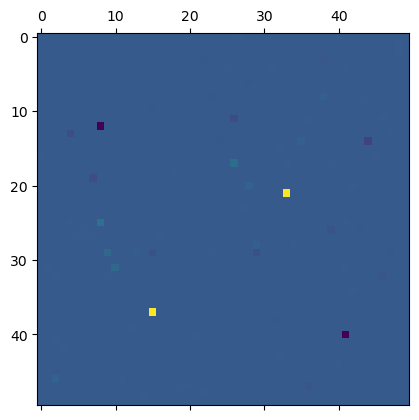

In [98]:
plt.matshow(t)

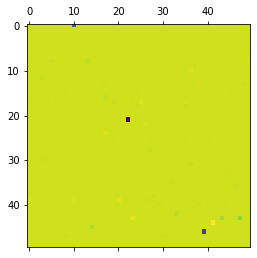

In [69]:
plt.matshow(tester)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cax = ax.matshow(tester)
#fig.colorbar(cax)

In [14]:
ev_switcher=data["best_grns"][check_at].detach().cpu().numpy()

In [15]:
import numpy as np

In [16]:
np.save("ev_switcher.npy",ev_switcher)

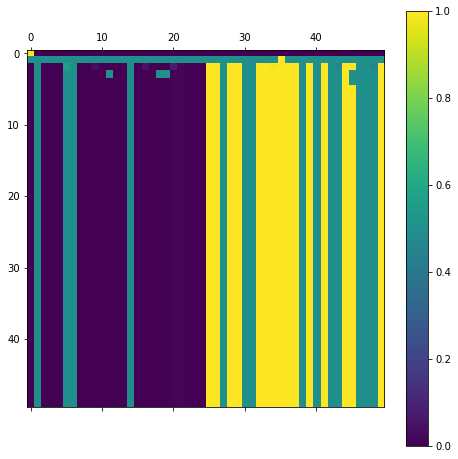

In [40]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(get_internal_states(data["best_grns"][check_at]).cpu()[:50,:])
fig.colorbar(cax)

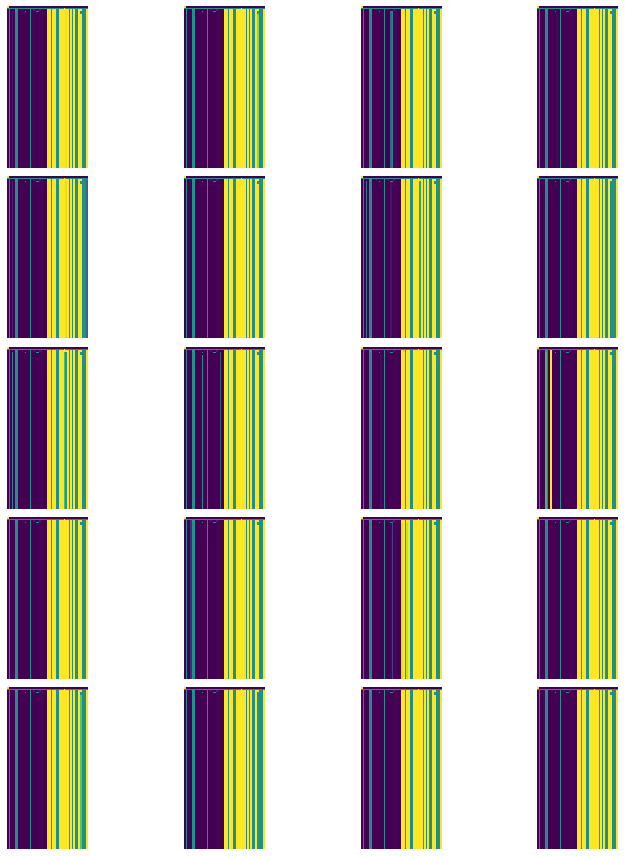

In [41]:
fig,axs = plt.subplots(nrows=5,ncols=4, figsize=(10,12))
for i,ax in enumerate(axs.flatten()):
  #start = get_internal_states(clones[i]).cpu()[:50,:]
  #end = get_internal_states(clones[i]).cpu()[-50:,:]
  #ax.imshow(torch.vstack((start, end)), interpolation="nearest")
  ax.imshow(get_internal_states(clones[i]).cpu(), interpolation="nearest")
  ax.axis("off")
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()